# Municipality movers and their effect on average age in Denmark

Imports and set magics:

In [4]:
# If the package geopandas isnt installed on your python enviroment, 
# you can do it using the below code:
#%pip install geopandas
# it can take a couple of minutes....

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
#from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

import ipywidgets as widgets
from IPython.display import display
import geopandas as gpd
import matplotlib.pyplot as plt

# user written modules
#import dataproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

I import a geojson file that contains data to draw a map of Danish municipalities.

In [6]:
#import json
import geopandas as gpd
mun_data = gpd.read_file('kommuner.geojson')
print(mun_data.head())


  KOMKODE     KOMNAVN                                           geometry
0    0766   Hedensted  POLYGON Z ((9.44919 55.86046 -999.00000, 9.460...
1    0766   Hedensted  POLYGON Z ((10.06198 55.83301 -999.00000, 10.0...
2    0561     Esbjerg  POLYGON Z ((8.59656 55.53506 -999.00000, 8.601...
3    0849  Jammerbugt  POLYGON Z ((9.78314 57.07319 -999.00000, 9.781...
4    0849  Jammerbugt  POLYGON Z ((9.19738 57.13868 -999.00000, 9.207...


Using the DST API i acces two datasets, <br>
GALDER: containing the average age in municipalities.<br>
FLY66:  containing the amount of movers to and from each municipality and their moving destination.

In [7]:
import pydst
dst = pydst.Dst(lang='en')

# GALDER
galder = dst.get_data(table_id = 'GALDER', variables={'KOMK':['*'], 'KØN':['*'], 'TID':['*']})
#galder.head()

In [8]:
galder.head()

,KOMK,KØN,TID,INDHOLD
0,All Denmark,Women,2019,42.5
1,All Denmark,Men,2019,40.8
2,All Denmark,Total,2019,41.7
3,Region Nordjylland,Women,2019,43.7
4,Region Nordjylland,Men,2019,41.8


In [9]:
# FLY66 flytninger mellem kommuner
fly = dst.get_data(table_id = 'FLY66', variables={'TILKOMMUNE':['*'], 'FRAKOMMUNE':['*'], 'ALDER':['*'], 'KØN':['*'], 'TID':['*']})
#fly.head(5)

In [10]:
fly.head(10)

,TILKOMMUNE,FRAKOMMUNE,ALDER,KØN,TID,INDHOLD
0,To Copenhagen,From Hørsholm,59 years,Women,2006,1
1,To Copenhagen,From Hørsholm,61 years,Women,2006,1
2,To Copenhagen,From Hørsholm,62 years,Men,2006,2
3,To Copenhagen,From Hørsholm,62 years,Women,2006,2
4,To Copenhagen,From Hørsholm,63 years,Men,2006,1
5,To Copenhagen,From Hørsholm,64 years,Women,2006,1
6,To Copenhagen,From Hørsholm,68 years,Men,2006,1
7,To Copenhagen,From Hørsholm,69 years,Women,2006,1
8,To Copenhagen,From Hørsholm,70 years,Men,2006,1
9,To Copenhagen,From Rudersdal,0 years,Men,2006,1


# Clean up of the moving data.
The data is divide by the ages and gender of the people moving. For my analysis i only want the total amount of movers between every municipality, so i use the groupby().sum() method to get the sum for every municipality pair. 

In [11]:
# renameing the municipality variables
fly['TILKOMMUNE'] = fly['TILKOMMUNE'].str.replace(r'To ', '')
fly['FRAKOMMUNE'] = fly['FRAKOMMUNE'].str.replace(r'From ', '')

# I find the sum of people moving for every municipality pair summed across all years.
fly_sum = fly.groupby(['TILKOMMUNE','FRAKOMMUNE'], as_index=False)['INDHOLD'].sum()

# the capital name is wrong, has to be changed
fly_sum['TILKOMMUNE'] = fly_sum['TILKOMMUNE'].replace(['Copenhagen'], 'København')
fly_sum['FRAKOMMUNE'] = fly_sum['FRAKOMMUNE'].replace(['Copenhagen'], 'København')

# the name of høje taastrup is wrong
fly_sum['TILKOMMUNE'] = fly_sum['TILKOMMUNE'].replace(['Høje-Taastrup'], 'Høje Taastrup')
fly_sum['FRAKOMMUNE'] = fly_sum['FRAKOMMUNE'].replace(['Høje-Taastrup'], 'Høje Taastrup')

fly_sum.head(5)


,TILKOMMUNE,FRAKOMMUNE,INDHOLD
0,Aabenraa,Aalborg,549
1,Aabenraa,Aarhus,2327
2,Aabenraa,Albertslund,55
3,Aabenraa,Allerød,24
4,Aabenraa,Assens,243


# Clean up of the average age dataset. 
The average age dataset also includes data for regions and in general in Denmark, as I am only interested in the municipalities i only keep data on municipalities in the dataset. 

In [12]:
# Excluding non municipality observations
I  = galder.KOMK.str.contains('Region')
I |= galder.KOMK.str.contains('All')
galder.loc[I, :]
galder = galder.loc[I == False] # keep everything else

# excluding the seperat rows for men and women, only keeping the total.
J = galder.KØN.str.contains('Total')
galder.loc[J, :]
galder = galder.loc[J == True] # keep everything else

# I will be looking at the 2020 values
galder = galder.loc[galder['TID'] == 2020]

# change some row names for consistency with the other data sets
galder['KOMK'] = galder['KOMK'].replace(['Copenhagen'], 'København')
galder['KOMK'] = galder['KOMK'].replace(['Høje-Taastrup'], 'Høje Taastrup')

# wont need the KØN column once ive restricted the data set to only contain the total.
galder.drop(columns=['KØN'], inplace=True)

galder.head(4)

,KOMK,TID,INDHOLD
2225,København,2020,36.1
2228,Frederiksberg,2020,40.0
2231,Ballerup,2020,42.3
2234,Brøndby,2020,41.7


In [13]:
# saves copys of the data as excel files to the folder.
#fly_sum.to_excel("fly_summeret.xlsx")
#mun_data.to_excel('geopandas_mun_names.xlsx')
#galder.to_excel('galder.xlsx')

# The relationship between moving and average age

In this section i will showcase the relationship between the ratio of people moving into and out of a municipality and the average age of the municipality.

I Calculate the ratio of people moving into and people moving away from each municipality.

In [14]:
#Crate two seperate datasets containing the sum of in-movers and out-movers in the municipality.
tilfly = fly_sum.groupby(['TILKOMMUNE'], as_index=False)['INDHOLD'].sum()
frafly = fly_sum.groupby(['FRAKOMMUNE'], as_index=False)['INDHOLD'].sum()

# The variables are renamed.
tilfly.rename(columns={'INDHOLD':'TILFLYT'},inplace=True)
frafly.rename(columns={'INDHOLD':'FRAFLYT'},inplace=True)

# ... and the datasets merged
fly_ratio = pd.merge(tilfly, frafly, 
                   left_on=['TILKOMMUNE'], right_on=['FRAKOMMUNE'],
                   how='inner')
 
# The ratio of in movers over out movers is calculated
fly_ratio['FLYTRATIO'] = fly_ratio['TILFLYT'] / fly_ratio['FRAFLYT']
fly_ratio['BRUTTOFLYT'] = (fly_ratio['TILFLYT'] + fly_ratio['FRAFLYT'])/1000

# The moving data is merged with the average age data. 
fly_ratio = pd.merge(fly_ratio, galder, 
                   left_on=['TILKOMMUNE'], right_on=['KOMK'],
                   how='inner')

fly_ratio.head(4)


,TILKOMMUNE,TILFLYT,FRAKOMMUNE,FRAFLYT,FLYTRATIO,BRUTTOFLYT,KOMK,TID,INDHOLD
0,Aabenraa,37793,Aabenraa,42710,0.884875,80.503,Aabenraa,2020,44.3
1,Aalborg,167724,Aalborg,157505,1.064880,325.229,Aalborg,2020,40.1
2,Aarhus,318163,Aarhus,305208,1.042446,623.371,Aarhus,2020,37.7
3,Albertslund,32916,Albertslund,35905,0.916753,68.821,Albertslund,2020,40.1


To showcase the relationship between the move ratio from 2006-2020 and the average age in the municipality in 2020 i create a bubble scatter plot with a trendline.

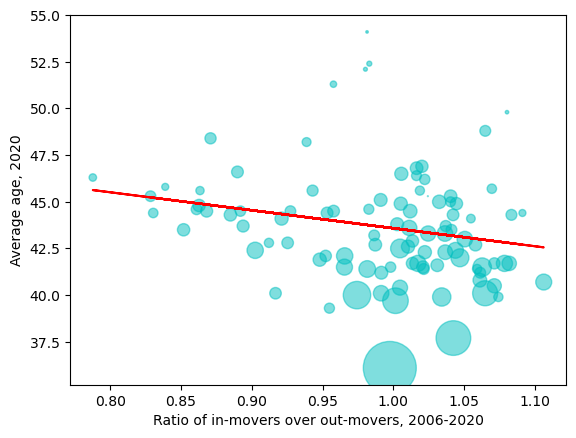

In [15]:
# A bubbel scatter plot is drawn over municipalities and their move ratio and average age
# The total amount of moving activity is used as the size of the bubbels. 
plt.scatter(fly_ratio['FLYTRATIO'], fly_ratio['INDHOLD'], s=fly_ratio['BRUTTOFLYT'] , c='c', alpha=0.5)

# a trendline is added.
z = np.polyfit(fly_ratio['FLYTRATIO'], fly_ratio['INDHOLD'], 1)
p = np.poly1d(z)
plt.plot(fly_ratio['FLYTRATIO'], p(fly_ratio['FLYTRATIO']), c='r')

# Labels and plot 
plt.xlabel("Ratio of in-movers over out-movers, 2006-2020")
plt.ylabel("Average age, 2020")
plt.show()

The correlation is calculated.

In [16]:
from scipy.stats import pearsonr

# the correlation between move ratio and average age is calculated:
corr, _ = pearsonr(fly_ratio['INDHOLD'],fly_ratio['FLYTRATIO'])

# In addition i also calculate the correlation between overall moving and 
corr_activity, _ = pearsonr(fly_ratio['BRUTTOFLYT'],fly_ratio['INDHOLD'])

covariance = np.cov(fly_ratio['INDHOLD'],fly_ratio['FLYTRATIO'])
print(f'The correlation between the move ratio and the average age is: {corr:.2f}')
print(f'The correlation between the overall moving activity and the average age is: {corr_activity:.2f}')


The correlation between the move ratio and the average age is: -0.23
The correlation between the overall moving activity and the average age is: -0.49


We can conclude that municipalitites with more movers on average have a higher average age. 
Does moving cause the aveage age to go up? - i think so.

We can also notice that larger bubbles tend to be low in the diagram: municipalities with alot of activity are usually younger. Municipalities with a lot of activity are usally municipalities with large populations: This leads me to the next question where we will look at where movers to the three largest cities in Denmark come from. 

# Mapping analysis

In this analysis i want to showcase from which regions the largest municipalities draw their movers from, to gain a deeper understanding of the moving patterns. 

First, I merge the geojson data with the datasets of interest, i use inner join, as i expect all observations to be present in both datasets and only want observations with complete data. 

In [17]:
# The moving data
fly_geo = pd.merge(mun_data, fly_sum, 
                   left_on=['KOMNAVN'], right_on=['FRAKOMMUNE'],
                   how='inner')

# The moving ratio and average age data
fly_ratio_geo = pd.merge(mun_data, fly_ratio, 
                   left_on=['KOMNAVN'], right_on=['TILKOMMUNE'],
                   how='inner')

Now the average age of the municipalities can be plotted. Below is drawn a map where each municipality maps is colored after its averae age. <br> Allerød kommune is missing

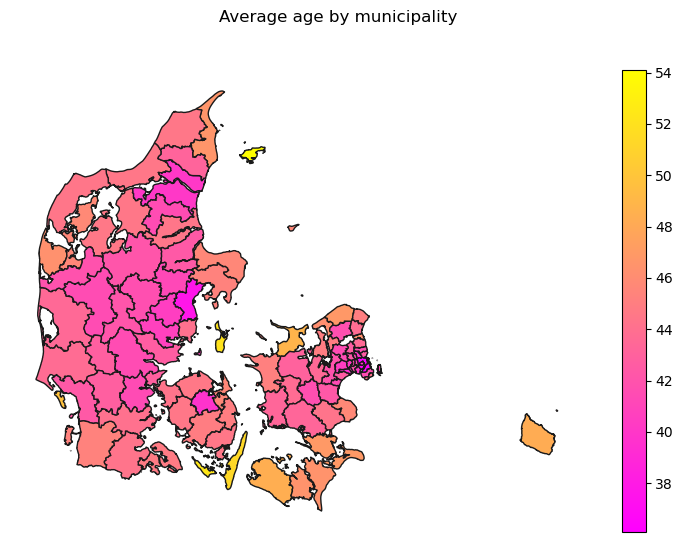

In [18]:
fig, ax = plt.subplots(1, figsize=(10,6))
fig.suptitle('Average age by municipality')
fly_ratio_geo.plot(column='INDHOLD', 
                        missing_kwds={"color": "lightgrey","edgecolor": "red","hatch": "///","label": "Missing values",}, 
                        cmap='spring', linewidth=1, ax=ax, edgecolor='0.1', 
                        legend = True)


ax.axis('off')
#fig.savefig('average_age.pdf')

Generally the municipalities which contain major cities and universities, like Copenhagen, Aarhus, Odense and Ålborg, have a lower average age. Inparticular the islands like læsø, Langeland, Samsø and Ærø have the highest average ages. 

# The interactive Map of movers origin municipalities
Next I create an interactive map that shows where movers originated for the selected municipality. 
- Try selecting the municipalities with major cities: København, Aarhus, Odensen or Aalborg.

In [52]:
# The drop down menue is created from a list of all municipality names
mun = ['Aabenraa', 'Aalborg', 'Aarhus', 'Albertslund', 'Allerød', 'Assens', 'Billund', 'Ballerup', 'Bornholm', 'Brøndby', 'Brønderslev', 'Dragør', 'Egedal', 'Esbjerg', 
        'Faaborg-Midtfyn', 'Favrskov', 'Fanø', 'Faxe', 'Fredensborg', 'Fredericia', 'Frederikshavn', 'Frederiksberg', 'Frederikssund', 'Furesø', 'Gentofte', 'Gladsaxe', 
        'Glostrup', 'Greve', 'Gribskov', 'Guldborgsund', 'Haderslev', 'Halsnæs', 'Hedensted', 'Herlev', 'Herning', 'Hillerød', 'Hjørring', 'Holbæk', 'Holstebro', 'Horsens', 
        'Hørsholm', 'Høje Taastrup', 'Ikast-Brande', 'Ishøj', 'Jammerbugt', 'Kalundborg', 'Kerteminde', 'Kolding', 'København', 'Køge', 'Langeland', 'Lemvig', 'Lejre', 
        'Lolland', 'Lyngby-Taarbæk', 'Mariagerfjord', 'Middelfart', 'Morsø', 'Norddjurs', 'Nordfyns', 'Næstved', 'Nyborg', 'Nørresundby', 'Odder', 'Odense', 'Odsherred', 
        'Randers', 'Rebild', 'Ringkøbing-Skjern', 'Ringsted', 'Roskilde', 'Rudersdal', 'Rødovre', 'Samsø', 'Silkeborg', 'Skanderborg', 'Skive', 'Slagelse', 'Solrød', 'Sorø', 
        'Stevns', 'Struer', 'Svendborg', 'Sønderborg', 'Tårnby', 'Thisted', 'Tønder', 'Vallensbæk', 'Varde', 'Vejen', 'Vejle', 'Vesthimmerlands', 'Viborg']

dropdown = widgets.Dropdown(options=mun, value="København", description='Select Municipality')

# Load the initial map data
selected_mun = dropdown.value
fly_geo_selected = fly_geo[fly_geo['TILKOMMUNE'] == selected_mun]

# Function to update the map plot
def plot_map(selected_mun):
    fly_geo_selected = fly_geo[fly_geo['TILKOMMUNE'] == selected_mun]
    
    fig, ax = plt.subplots(1, figsize=(10, 6))
    fig.suptitle(f'Map the origin of movers to the municipality: {selected_mun}')
    
    fly_geo_selected.plot(column='INDHOLD',
                          cmap='Greens',
                          linewidth=1,
                          ax=ax,
                          edgecolor='0.1',
                          legend=True,
                          scheme='quantiles')
    
    ax.axis('off')
    plt.show()

# Create the interactive plot
interactive_plot = widgets.interactive(plot_map, selected_mun=dropdown)

# Display the dropdown menu and plot
display(interactive_plot)

interactive(children=(Dropdown(description='Select Municipality', index=48, options=('Aabenraa', 'Aalborg', 'A…

It is very clear that movers generally either come from the surrounding area, or one of the other major cities: people moving to Arhus mostly come from central Jutland or Copenhagne, Odense or Aalborg. Movers to copenhagen mostly come from Sjælland or Aarhus, Odense and Ålborg. 

# Conclusion

In this project I have explored the relationship between moving patterns in Denmark and differences in average age between municipalities. 
<br>
<br>
I found that municipalities where more people move to, than from, tend to have a younger average age than municipalities with more movers from than to. 
<br>
<br>
We also saw that younger municipalities tend to be larger and have more moving activity in general. 
<br>
<br>
I conclude that the movement patterns in Denmark is a cause of differences in average age acroos municipalities and that major cities draw people living in other major cities or the surrounding area. This suggests that major cities are more attractive for younger people and that this is the driver behind their population growths. 